In [1]:
import numpy as np
import pandas as pd
import string
import pickle

import sklearn
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import sent_tokenize

## Data Loading and Splits

In [2]:
filename = 'classification_data/final_annotated_data_consistent.csv'
df = pd.read_csv(filename)

print(df.is_answerable_orig.value_counts())
print('Total', len(df))

N    1574
S    1034
Y    1020
Name: is_answerable_orig, dtype: int64
Total 3629


In [3]:
def print_stats(df, name='df'):
    print(name.upper())
    print('Length = %d' % len(df))
    print('IsAnswerableOrig Counts')
    print(df.is_answerable_orig.value_counts())
    print('IsAnswerableNew Counts')
    print(df.is_answerable_new.value_counts())
    print()

In [4]:
train_df = df[~df.expert]
test_df = df[df.expert]
test_df = test_df[test_df.is_answerable_new.notnull()]

print_stats(train_df, 'train')
print_stats(test_df, 'test')

TRAIN
Length = 3348
IsAnswerableOrig Counts
N    1436
S     958
Y     954
Name: is_answerable_orig, dtype: int64
IsAnswerableNew Counts
Series([], Name: is_answerable_new, dtype: int64)

TEST
Length = 281
IsAnswerableOrig Counts
N    138
S     76
Y     66
Name: is_answerable_orig, dtype: int64
IsAnswerableNew Counts
N    134
S     77
Y     70
Name: is_answerable_new, dtype: int64



In [5]:
# Column Renames
cols = ['question', 'review0', 'review1', 'review2', 'review3', 'review4', 'is_answerable']

train_df = train_df.rename(columns={'is_answerable_orig': 'is_answerable'})[cols]

test_df = test_df.rename(columns={'is_answerable_orig': 'is_answerable', 
                                  'is_answerable_new': 'is_answerable_human'})[cols + ['is_answerable_human']]


def filter_data(df):
    print(len(df))
    df = df[df.is_answerable.notnull()]
    print(len(df))
    df = df[df.review0.notnull()]
    print(len(df))
    return df

train_df = filter_data(train_df)

print('\n')

test_df = filter_data(test_df)
test_df_human = test_df[test_df.is_answerable_human.notnull()]
print(len(test_df))

3348
3348
3303


281
280
134
134


In [6]:
train_df, validate_df = np.split(train_df.sample(frac=1), [int(.8*len(train_df))])

In [7]:
len(train_df), len(validate_df), len(test_df)

(2642, 661, 134)

In [8]:
def labels(df):
    df['label'] = df.is_answerable.apply(lambda x: label_map[x])
    return df['label']

def get_reviews(row):
    all_reviews = ''
    for key in ['review0', 'review1', 'review2', 'review3', 'review4']:
        if not isinstance(row[key], float):
            all_reviews += row[key].strip(' ').strip('-')
            all_reviews += ' '
    return all_reviews.strip()

def add_reviews(df):
    df['reviews'] = df.apply(lambda x: get_reviews(x), axis = 1)
    return df

label_map = {'N': 0, 'S': 1, 'Y': 1, 'A': 1}
for i, j in zip([1, 2, 3], [1, 1, 0]):
    label_map[i] = j
    label_map[str(i)] = j

train_df, test_df, validate_df = list(map(add_reviews, [train_df, test_df, validate_df]))
train_labels, test_labels, validate_labels = list(map(labels, [train_df, test_df, validate_df]))

## TF IDF Vectorizer

In [9]:
"""
df = pd.read_csv('classification_data/train-qar_sample_100000.csv')
df = add_reviews(df)
print(len(df))

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer.fit(list(df.question.values) + list(df.reviews.values))

with open('classification_data/q_classification_vectorizer.pkl', 'wb') as fp:
    pickle.dump(tfidf_vectorizer, fp)
"""

"\ndf = pd.read_csv('classification_data/train-qar_sample_100000.csv')\ndf = add_reviews(df)\nprint(len(df))\n\ntfidf_vectorizer = TfidfVectorizer(stop_words='english')\ntfidf_vectorizer.fit(list(df.question.values) + list(df.reviews.values))\n\nwith open('classification_data/q_classification_vectorizer.pkl', 'wb') as fp:\n    pickle.dump(tfidf_vectorizer, fp)\n"

In [10]:
with open('classification_data/q_classification_vectorizer.pkl', 'rb') as fp:
    tfidf_vectorizer = pickle.load(fp)

In [11]:
len(tfidf_vectorizer.vocabulary_)

158752

## w2v Vectorizer

In [54]:
with open('classification_data/q_classification_w2v_vectorizer.pkl', 'rb') as fp:
    w2v_vectorizer = pickle.load(fp)

In [20]:
import numpy as np

with open("classification_data/glove.6B.300d.txt", "rb") as lines:
    w2v = {str(line.split()[0].decode('UTF-8')): np.array(list(map(float, line.split()[1:])))
           for line in lines}

In [21]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 300

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [22]:
w2v_vectorizer = MeanEmbeddingVectorizer(w2v)

In [53]:
with open('classification_data/q_classification_w2v_vectorizer.pkl', 'wb') as fp:
    pickle.dump(w2v_vectorizer, fp)

## Features

In [23]:
df = train_df

In [24]:
train_df_raw, test_df_raw, validate_df_raw = list(map(lambda x: x.copy(), [train_df, test_df, validate_df]))

In [25]:
def tokenize(text):
    punctuations = string.punctuation.replace("\'", '')

    for ch in punctuations:
        text = text.replace(ch, " " + ch + " ")

    tokens = text.split()
    for i, token in enumerate(tokens):
        if not token.isupper():
            tokens[i] = token.lower()
    return tokens

In [26]:
"""
x = vectorizer.transform(['It is a total idiot'])
y = vectorizer.transform(['It is not a total idiocy'])

print(type(x), '|\n', x.shape, '|\n', x, '|\n', len(x.toarray()[0]))
print("-"*50)
print(type(y), '|\n', y.shape, '|\n', y, '|\n', len(y.toarray()[0]))
print("-"*50)
print(x.toarray().dot(y.toarray().transpose())[0][0])
"""

'\nx = vectorizer.transform([\'It is a total idiot\'])\ny = vectorizer.transform([\'It is not a total idiocy\'])\n\nprint(type(x), \'|\n\', x.shape, \'|\n\', x, \'|\n\', len(x.toarray()[0]))\nprint("-"*50)\nprint(type(y), \'|\n\', y.shape, \'|\n\', y, \'|\n\', len(y.toarray()[0]))\nprint("-"*50)\nprint(x.toarray().dot(y.toarray().transpose())[0][0])\n'

In [57]:
def n_intersection(q, r):
    return len(set(q).intersection(set(r)))

def w2v_sim(q, r):
    # dot product of q and r as w2v vectors
    q_vec = w2v_vectorizer.transform([q])
    r_vec = w2v_vectorizer.transform([r])
    return q_vec.dot(r_vec.transpose())[0][0]

def tf_idf_sim(q, r):
    # dot product of q and r as tfidf vectors
    q_vec = tfidf_vectorizer.transform([q])
    r_vec = tfidf_vectorizer.transform([r])
    return q_vec.dot(r_vec.transpose()).toarray()[0][0]

def tf_idf_sim_sentence(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = tfidf_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return max([q_vec.dot(tfidf_vectorizer.transform([r]).transpose()).toarray()[0][0] for r in rs])

def w2v_sim_sentence(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = w2v_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return max([q_vec.dot(w2v_vectorizer.transform([r]).transpose())[0][0] for r in rs])

def tf_idf_sim_sentence_mean(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = tfidf_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return np.mean([q_vec.dot(tfidf_vectorizer.transform([r]).transpose()).toarray()[0][0] for r in rs])

def w2v_sim_sentence_mean(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = w2v_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return np.mean([q_vec.dot(w2v_vectorizer.transform([r]).transpose())[0][0] for r in rs])

def add_features(df):
    df['q_tokens'] = df.question.apply(lambda x: tokenize(x))
    df['r_tokens'] = df.reviews.apply(lambda x: tokenize(x))
    df['r_sents'] = df.reviews.apply(lambda x: sent_tokenize(x))
    df['n_q'] = df.q_tokens.apply(lambda x: len(x))
    df['n_r'] = df.r_tokens.apply(lambda x: len(x))
    df['n_intersection'] = df.apply(lambda x: len(set(x.q_tokens).intersection(set(x.r_tokens))), axis=1)
    df['intr_frac'] = df.n_intersection / df.n_q
    df['tfidf'] = df.apply(lambda x: tf_idf_sim(x.question, x.reviews), axis=1)
    df['w2v'] = df.apply(lambda x: w2v_sim(x.question, x.reviews), axis=1)
    df['w2v_sent'] = df.apply(lambda x: w2v_sim_sentence(x.question, x.r_sents), axis=1)
    df['tfidf_sent'] = df.apply(lambda x: tf_idf_sim_sentence(x.question, x.r_sents), axis=1)
    df['w2v_sent_mean'] = df.apply(lambda x: w2v_sim_sentence_mean(x.question, x.r_sents), axis=1)
    df['tfidf_sent_mean'] = df.apply(lambda x: tf_idf_sim_sentence_mean(x.question, x.r_sents), axis=1)
    return df


In [58]:
train_df, test_df, validate_df = list(map(add_features, [train_df_raw, test_df_raw, validate_df_raw]))

## Feature Cols

In [29]:
X_cols = ['n_q', 'n_r', 'n_intersection', 'intr_frac']
Y_cols = 'label'

## Analysis

In [30]:
df = train_df

q = df.question.iloc[1]
r = df.reviews.iloc[1]
q_tokens = df.q_tokens.iloc[1]
r_tokens = df.r_tokens.iloc[1]

# q, r, set(q_tokens).intersection(set(r_tokens))

In [31]:
df[[Y_cols] + X_cols].groupby('label').mean()

,n_q,n_r,n_intersection,intr_frac
label,,,,
0,15.550222,328.865778,7.080889,0.468318
1,17.576137,379.308504,9.665788,0.586226


## Training

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

X_colss = [
    #X_cols + ['tfidf', 'tfidf_sent'],
    #X_cols + ['w2v', 'w2v_sent'],
    #X_cols + ['w2v_sent_mean', 'tfidf_sent_mean'],
    X_cols + ['w2v_sent', 'tfidf_sent', 'w2v_sent_mean', 'tfidf_sent_mean'],
    X_cols + ['w2v_sent', 'tfidf_sent'],
    
    X_cols + ['tfidf_sent'],
    X_cols + ['w2v_sent'],
    X_cols + ['tfidf', 'tfidf_sent', 'w2v', 'w2v_sent'],
]

n_col_set = len(X_colss)
modelss = []

for j in range(n_col_set):
    models = []
    models.append(LogisticRegression(C=1))
    models.append(LogisticRegression(C=100))
    models.append(DecisionTreeClassifier(max_depth=4))
    models.append(RandomForestClassifier(n_estimators=3, max_depth=4))

    for i in range(len(models)):
        models[i].fit(train_df[X_colss[j]].values, train_df[Y_cols].values)
    modelss.append(models)

/Users/rchanda/Acads/Fall-2018/Capstone/eqa_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rchanda/Acads/Fall-2018/Capstone/eqa_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rchanda/Acads/Fall-2018/Capstone/eqa_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rchanda/Acads/Fall-2018/Capstone/eqa_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rchanda/Acads/Fall-2018/Capstone/eqa_

In [75]:
from sklearn.metrics import classification_report

for j, models in enumerate(modelss):
    for i, model in enumerate(models):
        print(j, i)
        predictions = model.predict(validate_df[X_colss[j]].values)
        print(pd.Series(predictions).value_counts())
        print(classification_report(validate_df[Y_cols].values, predictions))

0 0
1    424
0    237
dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.54      0.58       276
           1       0.70      0.77      0.74       385

   micro avg       0.68      0.68      0.68       661
   macro avg       0.67      0.66      0.66       661
weighted avg       0.67      0.68      0.67       661

0 1
1    424
0    237
dtype: int64
              precision    recall  f1-score   support

           0       0.63      0.54      0.58       276
           1       0.70      0.77      0.74       385

   micro avg       0.68      0.68      0.68       661
   macro avg       0.67      0.66      0.66       661
weighted avg       0.67      0.68      0.67       661

0 2
1    478
0    183
dtype: int64
              precision    recall  f1-score   support

           0       0.64      0.42      0.51       276
           1       0.67      0.83      0.74       385

   micro avg       0.66      0.66      0.66       661
   macro avg       0.65

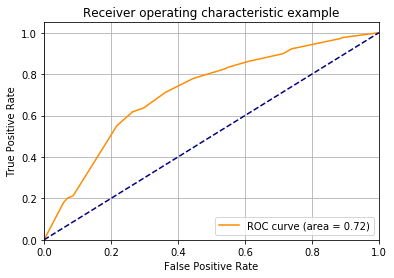

[0.58245083 0.60450161 0.60517799 0.63506261 0.63720074 0.66267465
 0.67864693 0.68172043 0.70921986 0.73262032 0.74923547 0.76527331
 0.77941176 0.77358491 0.80208333 0.81176471 1.        ] [1.         0.97662338 0.97142857 0.92207792 0.8987013  0.86233766
 0.83376623 0.82337662 0.77922078 0.71168831 0.63636364 0.61818182
 0.55064935 0.21298701 0.2        0.17922078 0.        ] [0.12711864 0.13636364 0.24864865 0.29545455 0.33606557 0.39495798
 0.46153846 0.50310559 0.51592357 0.53757225 0.63333333 0.65384615
 0.73684211 0.74468085 0.76923077 0.84      ]


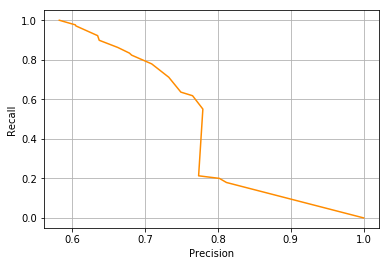

In [89]:
from sklearn.metrics import auc, roc_curve
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_curves(model):
    probs = model.predict_proba(validate_df[X_colss[0]].values)[:,1]
    ytrue = validate_df[Y_cols].values

    fpr, tpr, thresholds = roc_curve(ytrue, probs, pos_label=1)
    score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % score)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    precision, recall, thresholds = precision_recall_curve(ytrue, probs)
    print(precision, recall, thresholds)
    plt.figure()
    plt.plot(precision, recall, color='darkorange')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.grid()
    plt.show()

    """
    thresholds = [0.25, 0.5, 0.75]
    for th in thresholds:
        #print(probs)
        predictions = [1 if prob > th else 0 for prob in probs]
        #predictions = model.predict(validate_df[X_cols].values)
        print(pd.Series(predictions).value_counts())
        print(classification_report(ytrue, predictions))
    """
    
    
plot_curves(modelss[0][0])

## Testing

In [94]:
from sklearn.metrics import classification_report

def predictions_k(model, X, k):
    probs = model.predict_proba(X)
    return probs[:, 1] >= k

modelss = [[model]]
for j, models in enumerate(modelss):
    for i, model in enumerate(models):
        predictions = model.predict(test_df[X_colss[j]].values)
        predictions = predictions_k(model, test_df[X_colss[j]].values, 0.7)
        print(pd.Series(predictions).value_counts())
        print(classification_report(test_df[Y_cols].values, predictions))

True     70
False    64
dtype: int64
              precision    recall  f1-score   support

           0       0.72      0.71      0.71        65
           1       0.73      0.74      0.73        69

   micro avg       0.72      0.72      0.72       134
   macro avg       0.72      0.72      0.72       134
weighted avg       0.72      0.72      0.72       134



## Human Performance

In [51]:
predictions = test_df_human.is_answerable_human.apply(lambda x: label_map[x]).values
labels = test_df_human.is_answerable.apply(lambda x: label_map[x]).values
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85        65
           1       0.83      0.93      0.88        69

   micro avg       0.87      0.87      0.87       134
   macro avg       0.87      0.86      0.86       134
weighted avg       0.87      0.87      0.86       134



## Saving

In [52]:
#with open('classification_data/q_classification_model_final.pkl', 'wb') as fp:
#    pickle.dump(modelss[4][2], fp)

In [84]:
with open('classification_data/q_classification_model_final.pkl', 'rb') as fp:
    model = pickle.load(fp)